# Поиск вставок

Будем искать вставки глядя на смещение GC (GC skew). Отрезки с аномальным для данной последовательности GC skew, скорее всего, и будут местами вставок. Поиск осуществим графическим способом.

## Case 1

Для начала посмотрим на график GC skew. Это уже позволит прикинуть место вставки с хорошей точностью. Отметим, что для такого приблизительного решения стоит немного поэкспериментировать с длиной "окон", для которых вычисляется GC skew, чтобы различия были лучше видны.

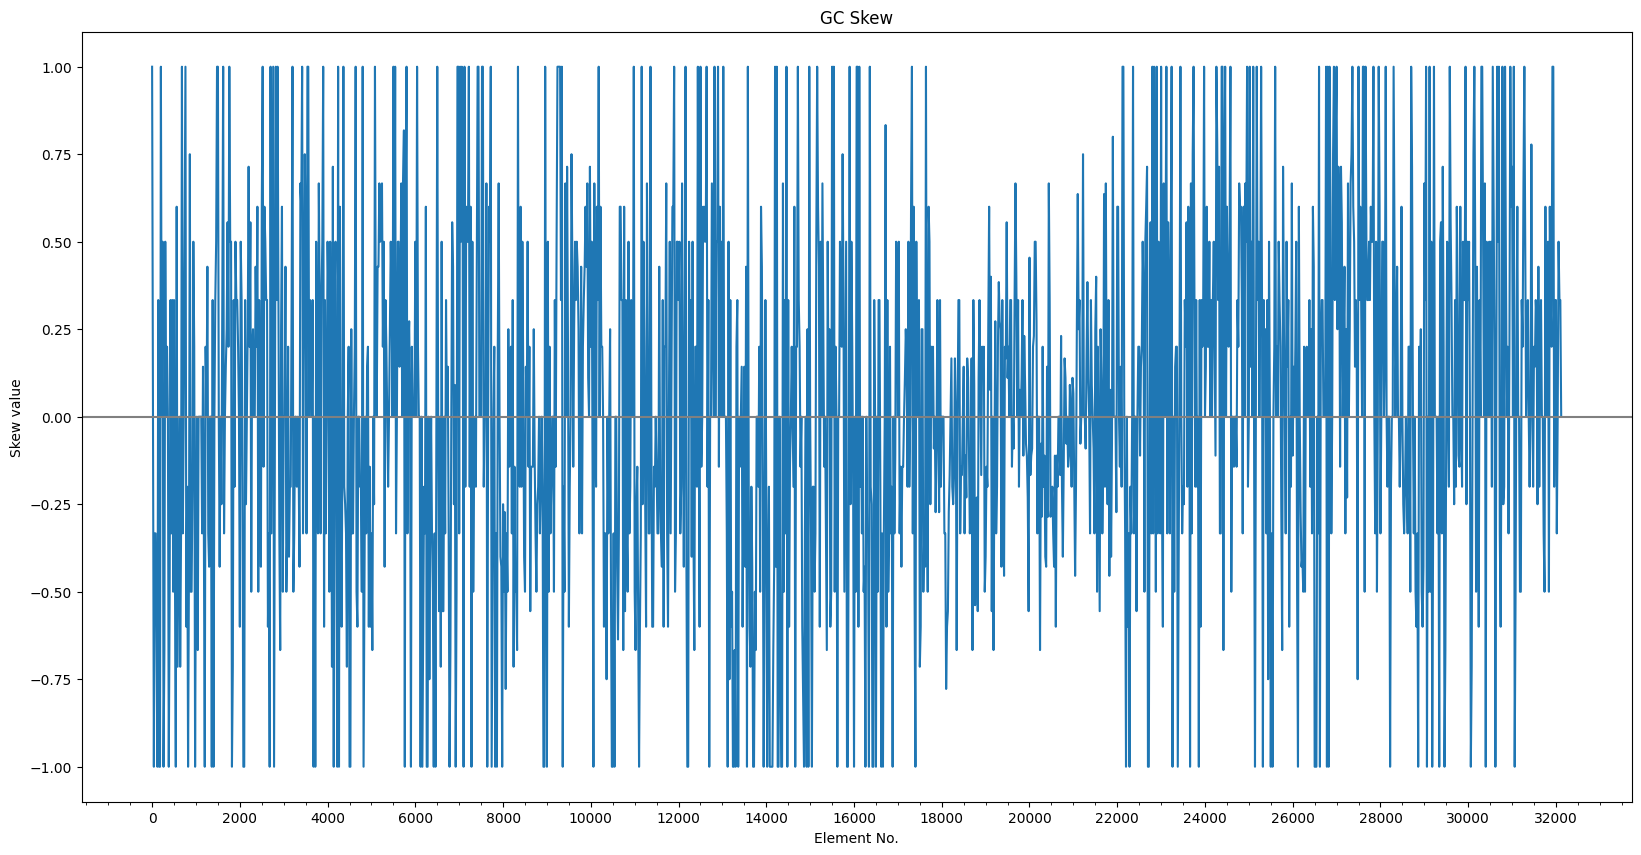

In [341]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("01.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


# gc_orig = SU.gc_fraction(seq_orig)
# print(f'Original record length: {seq_orig.__len__()}')
# print(f'Original GC: {gc_orig}')

current_sub = ""
current_max_insertion = ""

window_size = 20

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.xaxis.set_major_locator(MultipleLocator(2000))
ax.axhline(0, color='grey')
plt.show()


# for i in range(0, len(record_orig), 1):
#     print(i)
#     for j in range(i + min_size, len(record_orig)+1, step_size):
#         current_sub = record_orig[i:j]
#         # cur_dif = abs(gc_orig - SU.gc_fraction(current_sub))
#         # prev_dif = abs(gc_orig - SU.gc_fraction(current_max_insertion))

#         # wo_cur = record_orig[:i] + record_orig[j:]
#         # cur_dif = abs(gc_orig - SU.gc_fraction(current_sub))
#         SU.GC_skew()

#         # prev_dif = abs(gc_orig - SU.gc_fraction(current_max_insertion))
#         if (cur_dif > prev_dif):
#             current_max_insertion = current_sub
#             border_left = i
#             border_right = j
#             prev_dif = cur_dif


Можно заметить, что примерно между 17 500 и 22 500 элементами модуль GC skew в среднем намного ниже, чем до и после этого отрезка. Попробуем рассмотреть этот отрезок поближе.

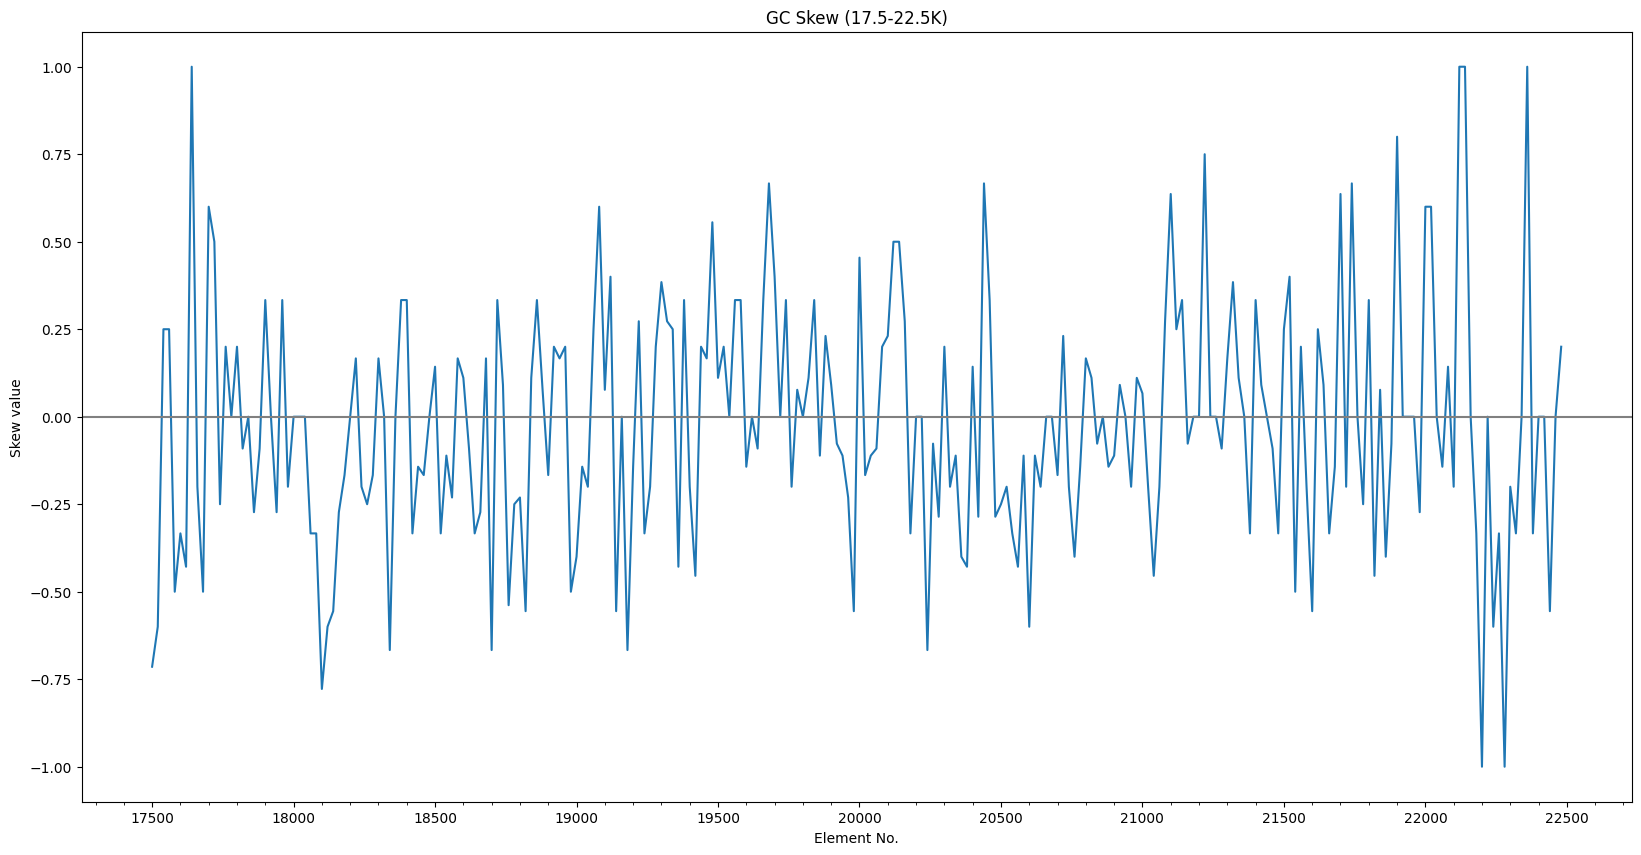

In [342]:
window_size = 20

border_left = 17500
border_right = 22500

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(100))
ax17_23.xaxis.set_major_locator(MultipleLocator(500))
ax17_23.axhline(0, color='grey')

plt.show()


Присмотримся к правому и левому концам отрезка поближе. Можно сделать размер "окна" вычисления GC skew поменьше.

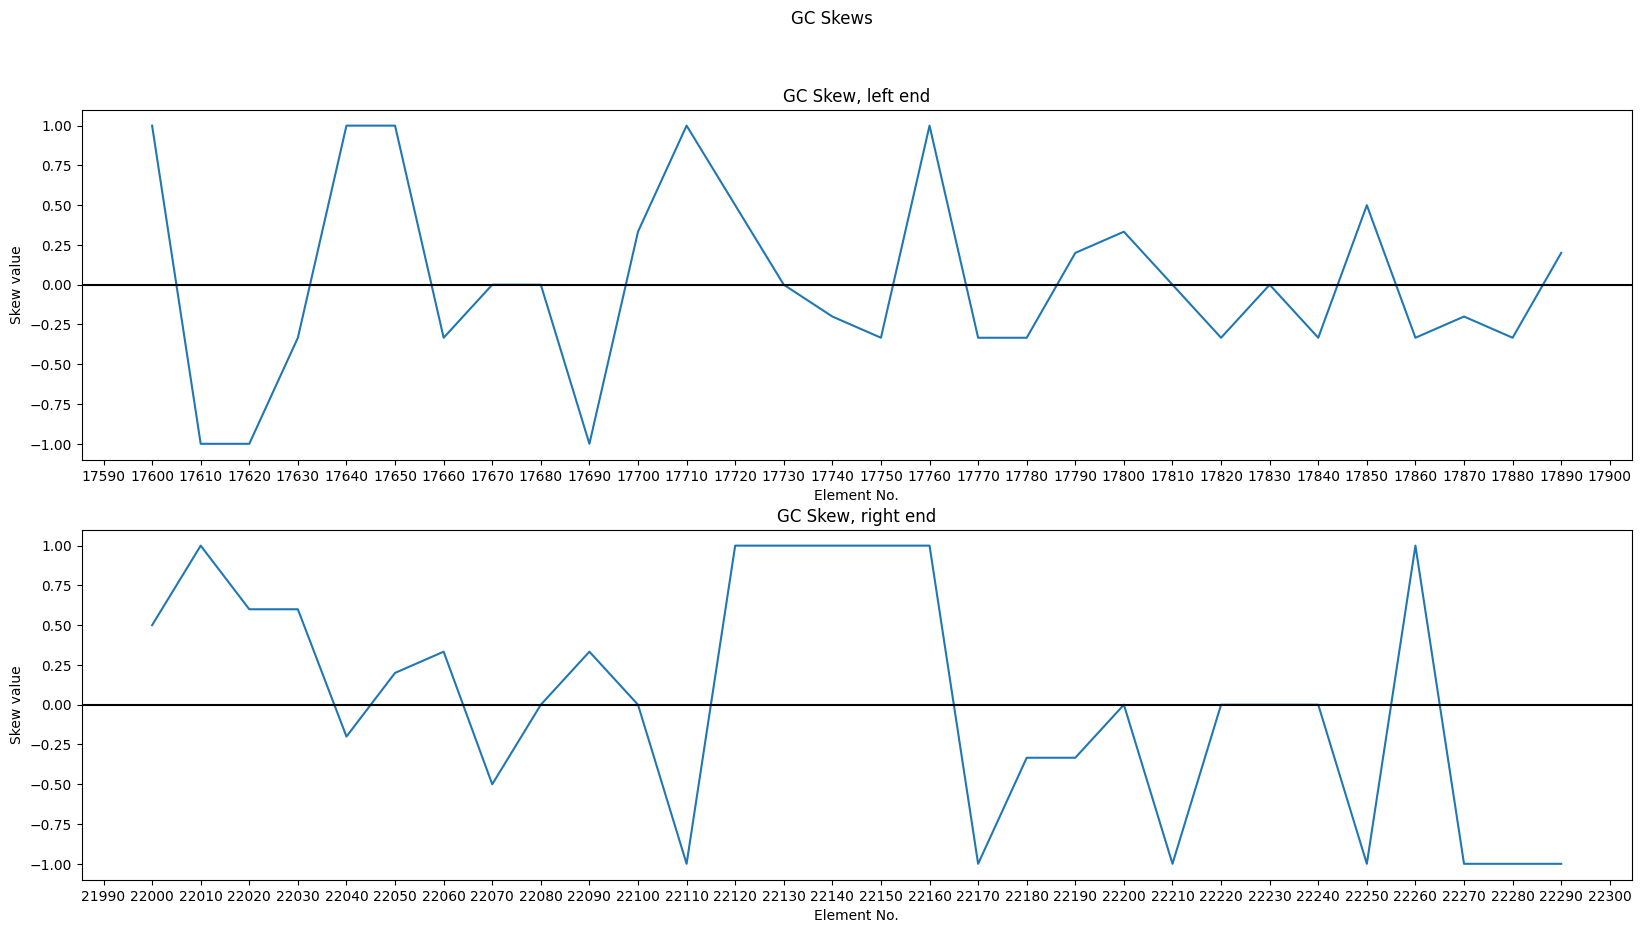

In [343]:
window_size1 = 10

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 17600
border_right_l = 17900

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(10))
ax_l.axhline(0, color='black')

border_left_r = 22000
border_right_r = 22300

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(10))
ax_r.axhline(0, color='black')

plt.show()


Снова уменьшим "окно" и приблизим масштаб ещё ближе?

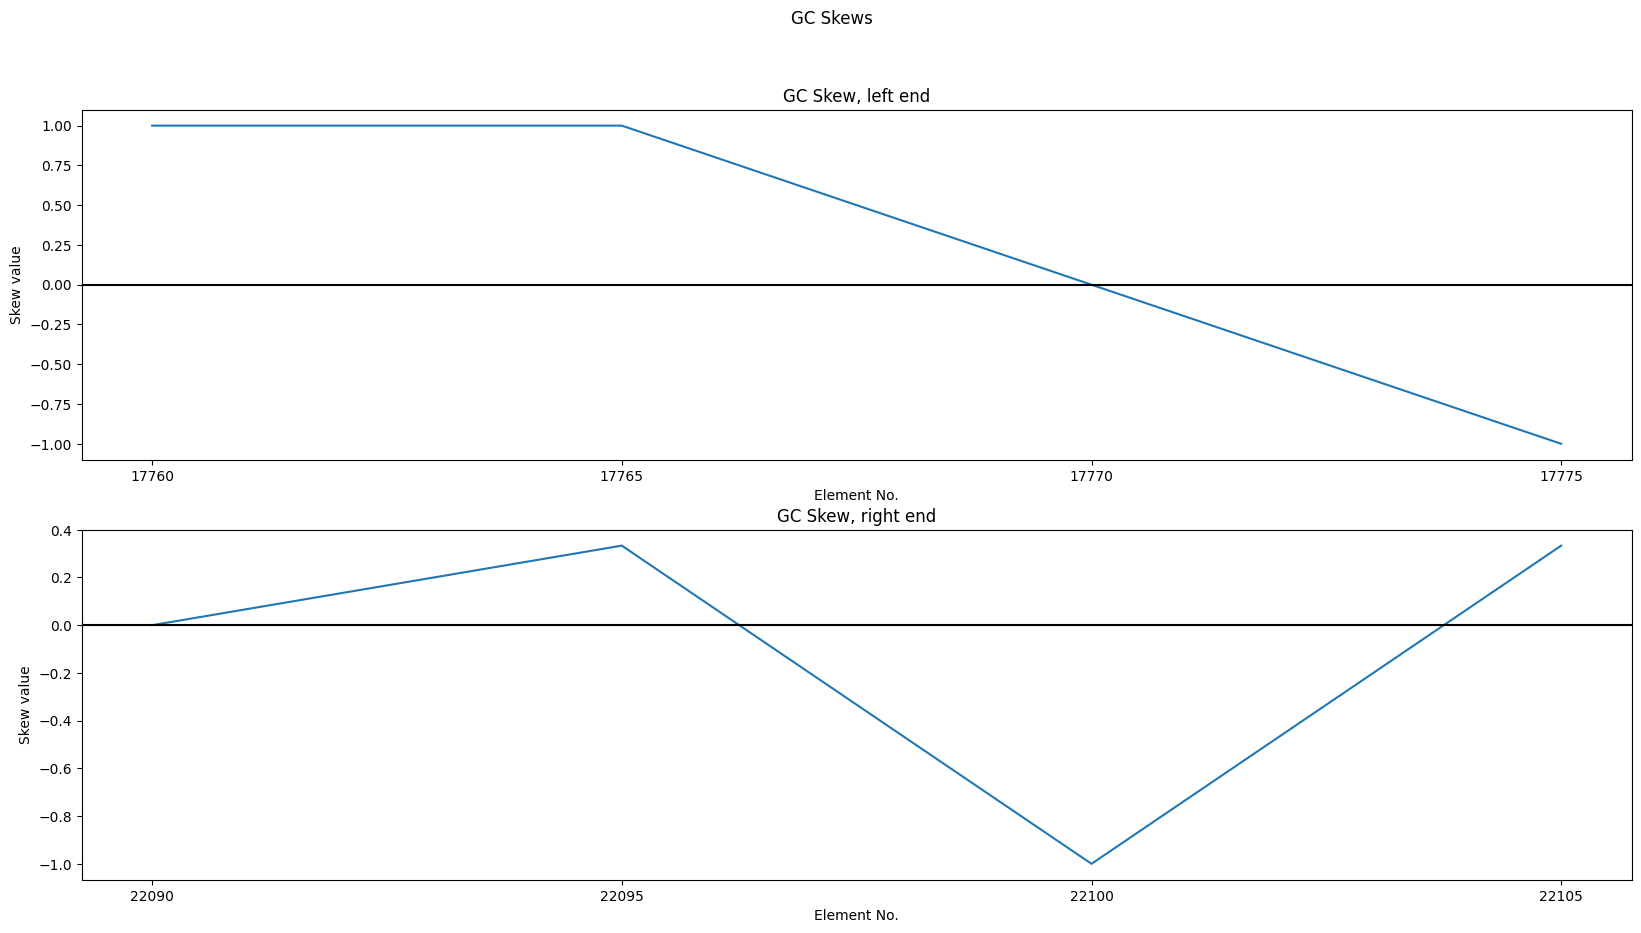

In [344]:
window_size1 = 5

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 17760
border_right_l = 17780

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(5))
ax_l.axhline(0, color='black')

border_left_r = 22090
border_right_r = 22110

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(5))
ax_r.axhline(0, color='black')

plt.show()


Вряд ли мы сможем получить места начала и конца вставки с большей точностью таким образом. 

#### Ответ

**Левая граница** = 17770

**Правая граница** = 22095

In [345]:
print(f'Insertion length: {current_max_insertion.__len__()}')
print(f'Borders: left - {border_left}; right - {border_right}')
print(f'Insertion GC: {SU.gc_fraction(current_max_insertion)}')

Insertion length: 0
Borders: left - 17500; right - 22500
Insertion GC: 0


## Case2

Original record length: 2393931
Original GC score: 0.551168768022136


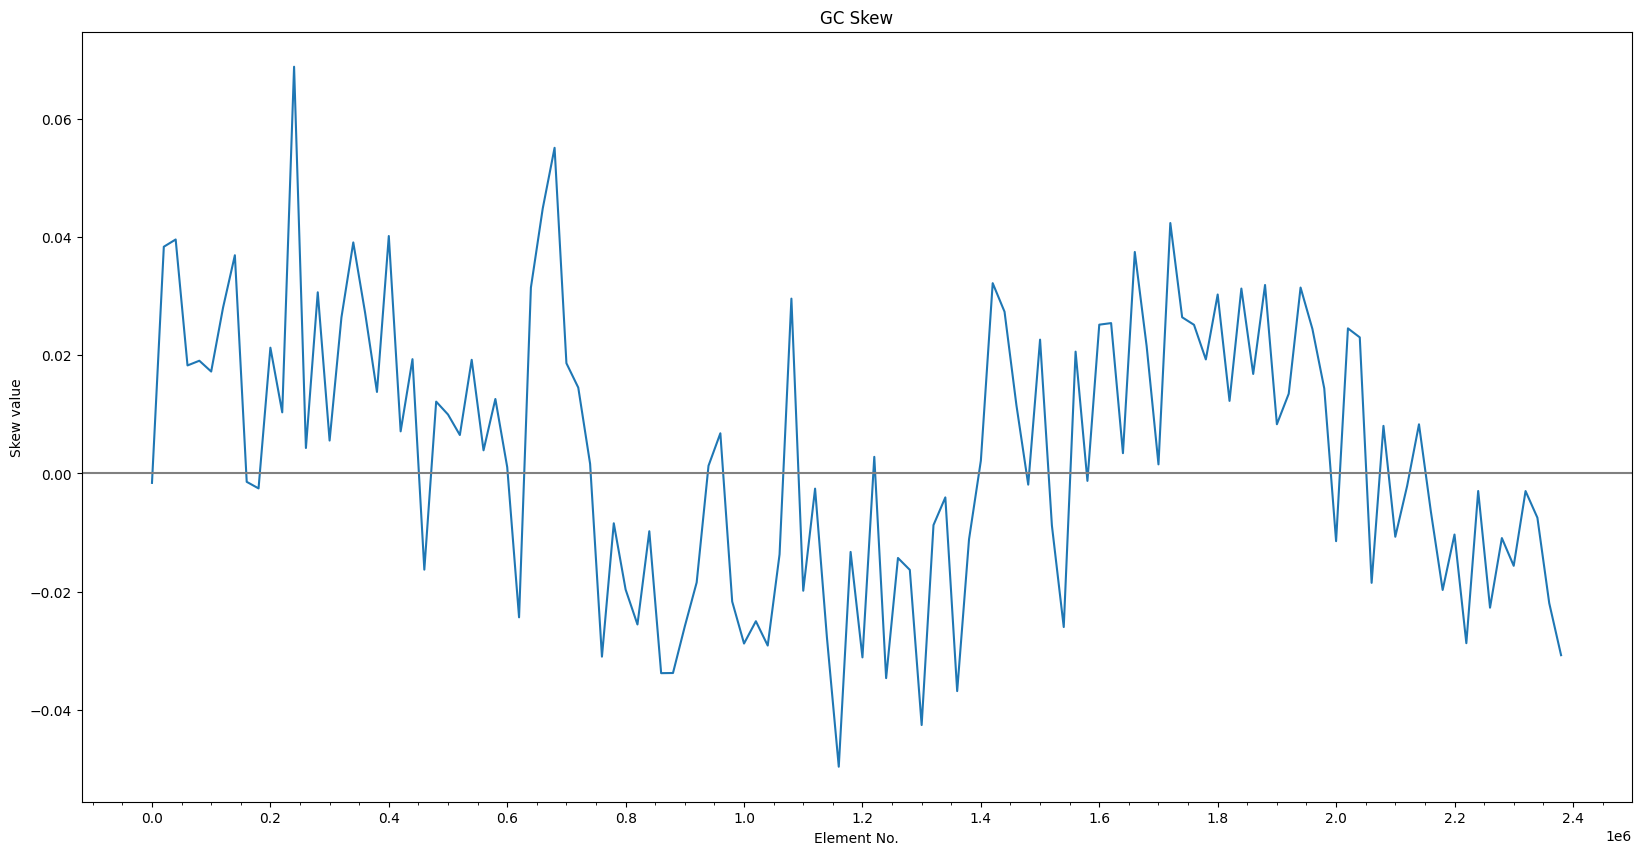

In [445]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("02.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


print(f'Original record length: {seq_orig.__len__()}')
print(f'Original GC score: {SU.gc_fraction(seq_orig)}')


current_sub = ""
current_max_insertion = ""

window_size = 20000

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(50000))
ax.xaxis.set_major_locator(MultipleLocator(200000))
ax.axhline(0, color='grey')
plt.show()


In [446]:
for 

SyntaxError: invalid syntax (1235331270.py, line 1)

In [ ]:
window_size = 20000

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(50000))
ax.xaxis.set_major_locator(MultipleLocator(200000))
ax.axhline(0, color='grey')
plt.show()

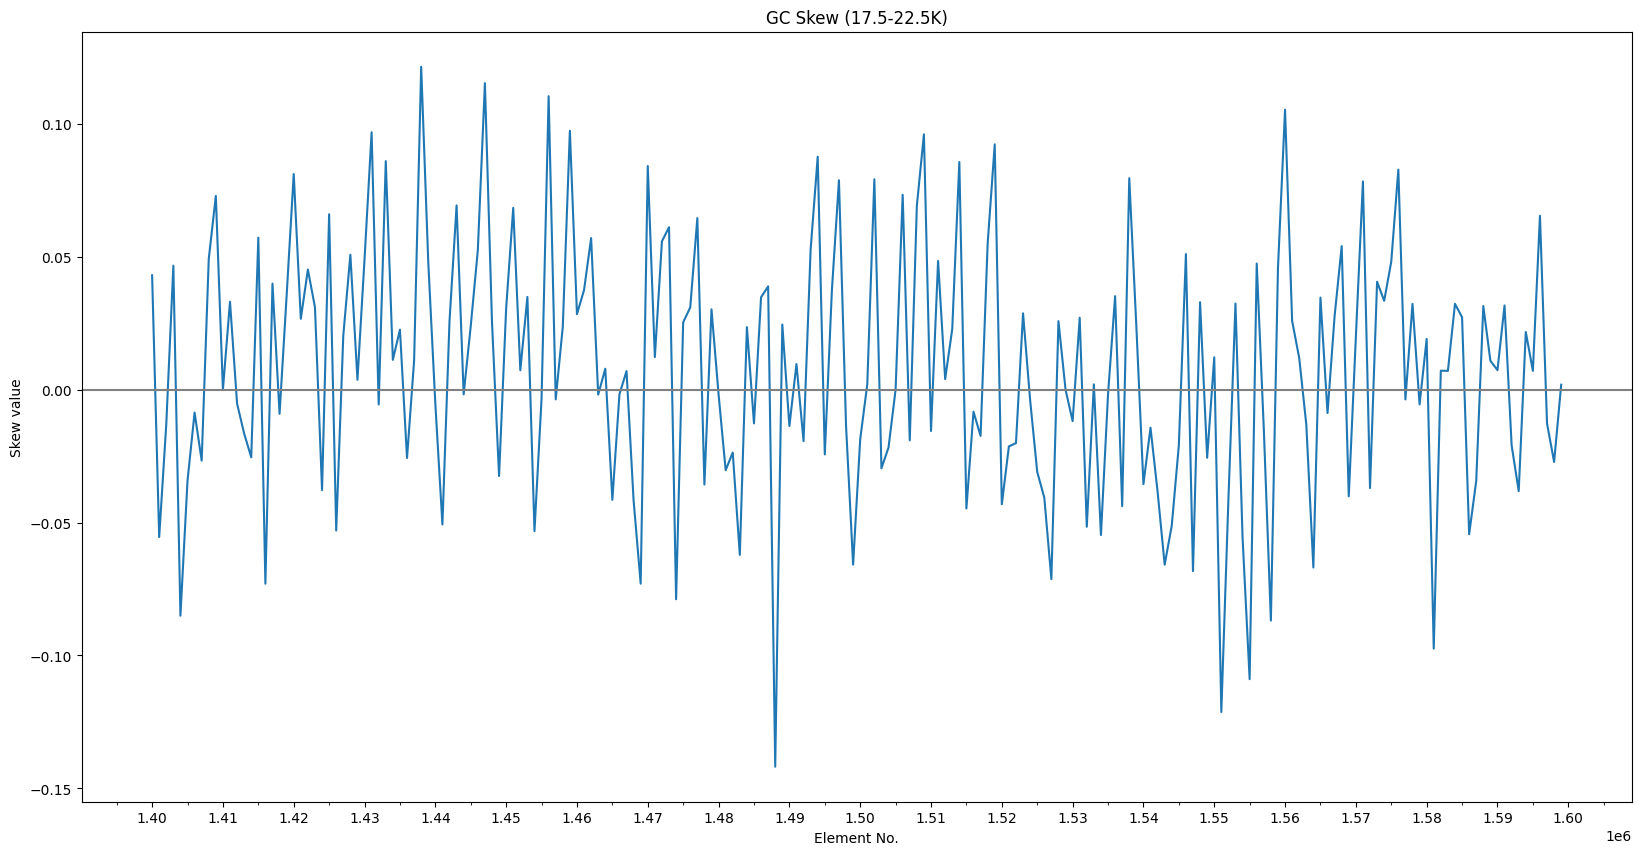

In [432]:
window_size = 1000

border_left = 1400 * 1000
border_right = 1600 * 1000

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(5000))
ax17_23.xaxis.set_major_locator(MultipleLocator(10000))
ax17_23.axhline(0, color='grey')

plt.show()


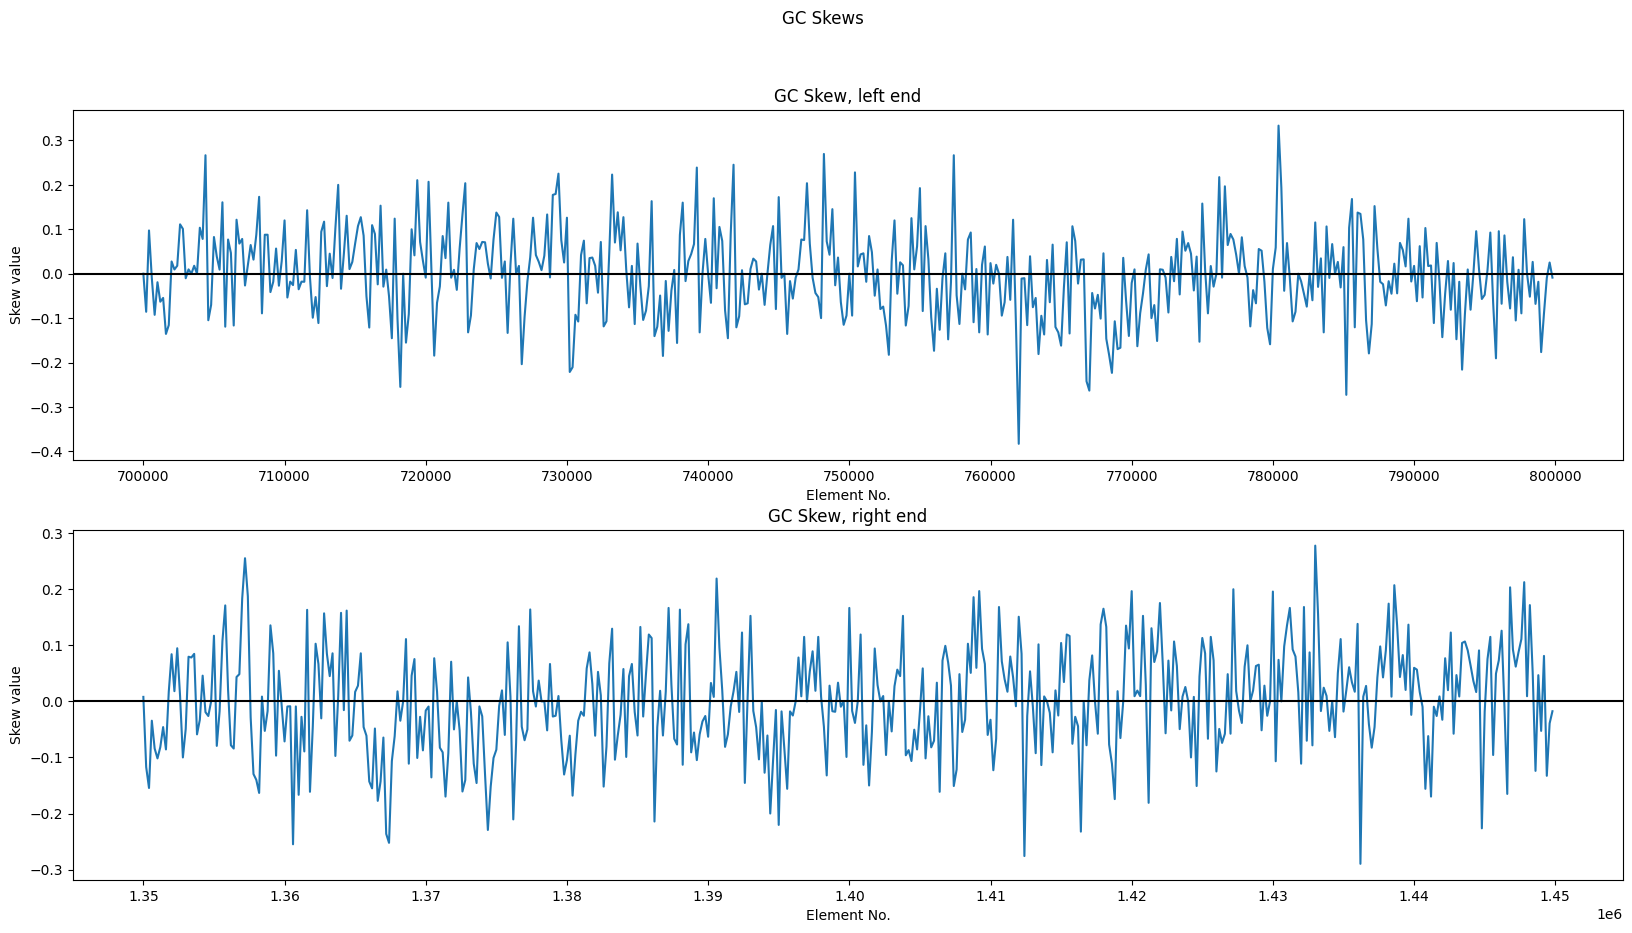

In [348]:
window_size1 = 200

fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 700000
border_right_l = 800000

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(10000))
ax_l.axhline(0, color='black')

border_left_r = 1350*1000
border_right_r = 1450*1000

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(10000))
ax_r.axhline(0, color='black')


## Case 3

Original record length: 19696


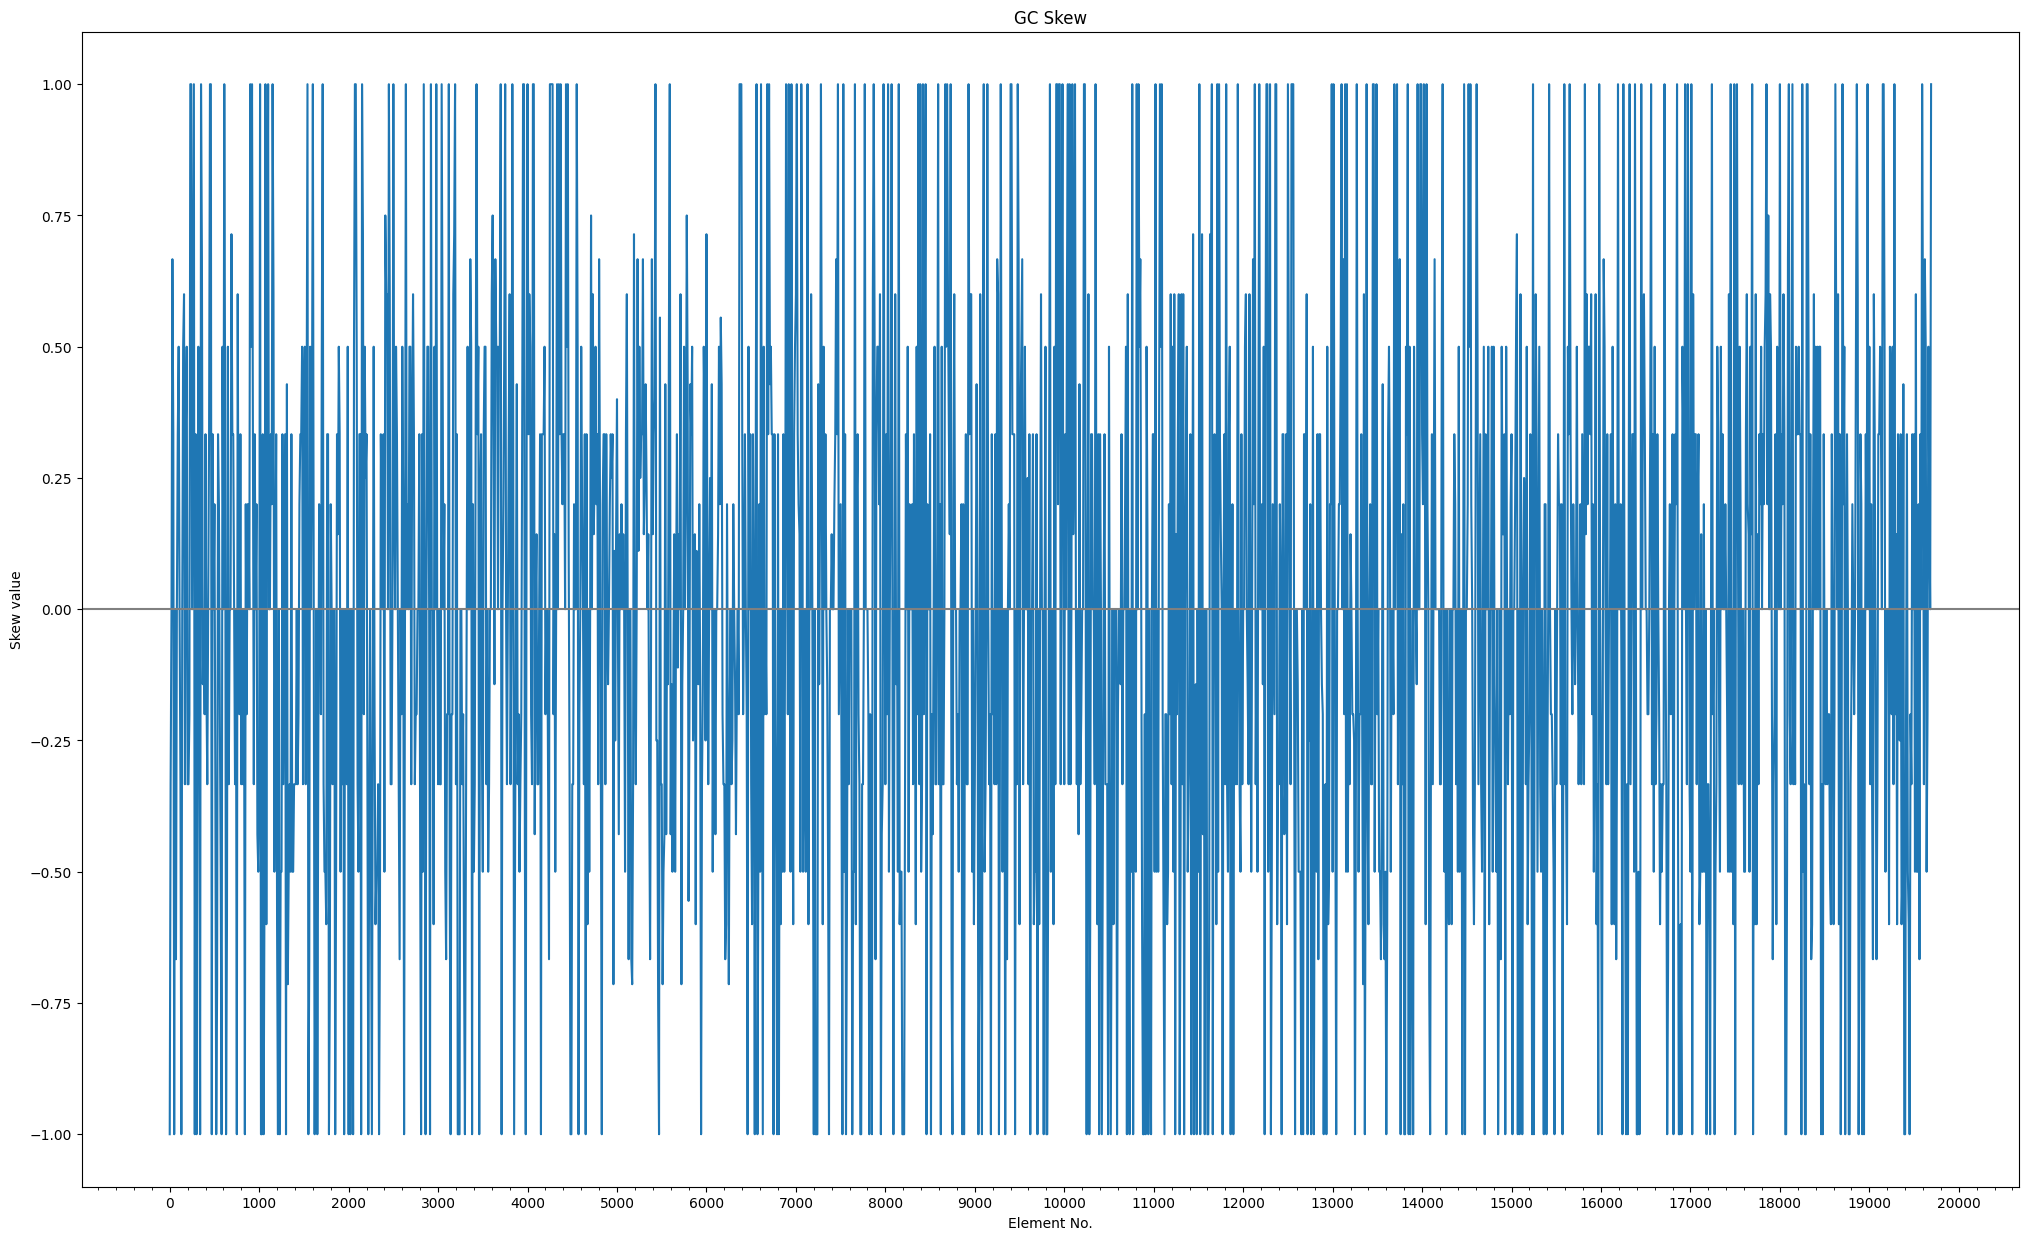

In [443]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("03.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


print(f'Original record length: {seq_orig.__len__()}')

current_sub = ""
current_max_insertion = ""

window_size = 10

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(25, 15))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.axhline(0, color='grey')
plt.show()


Между 2000 и 5000 аномально большое значение GC skew.

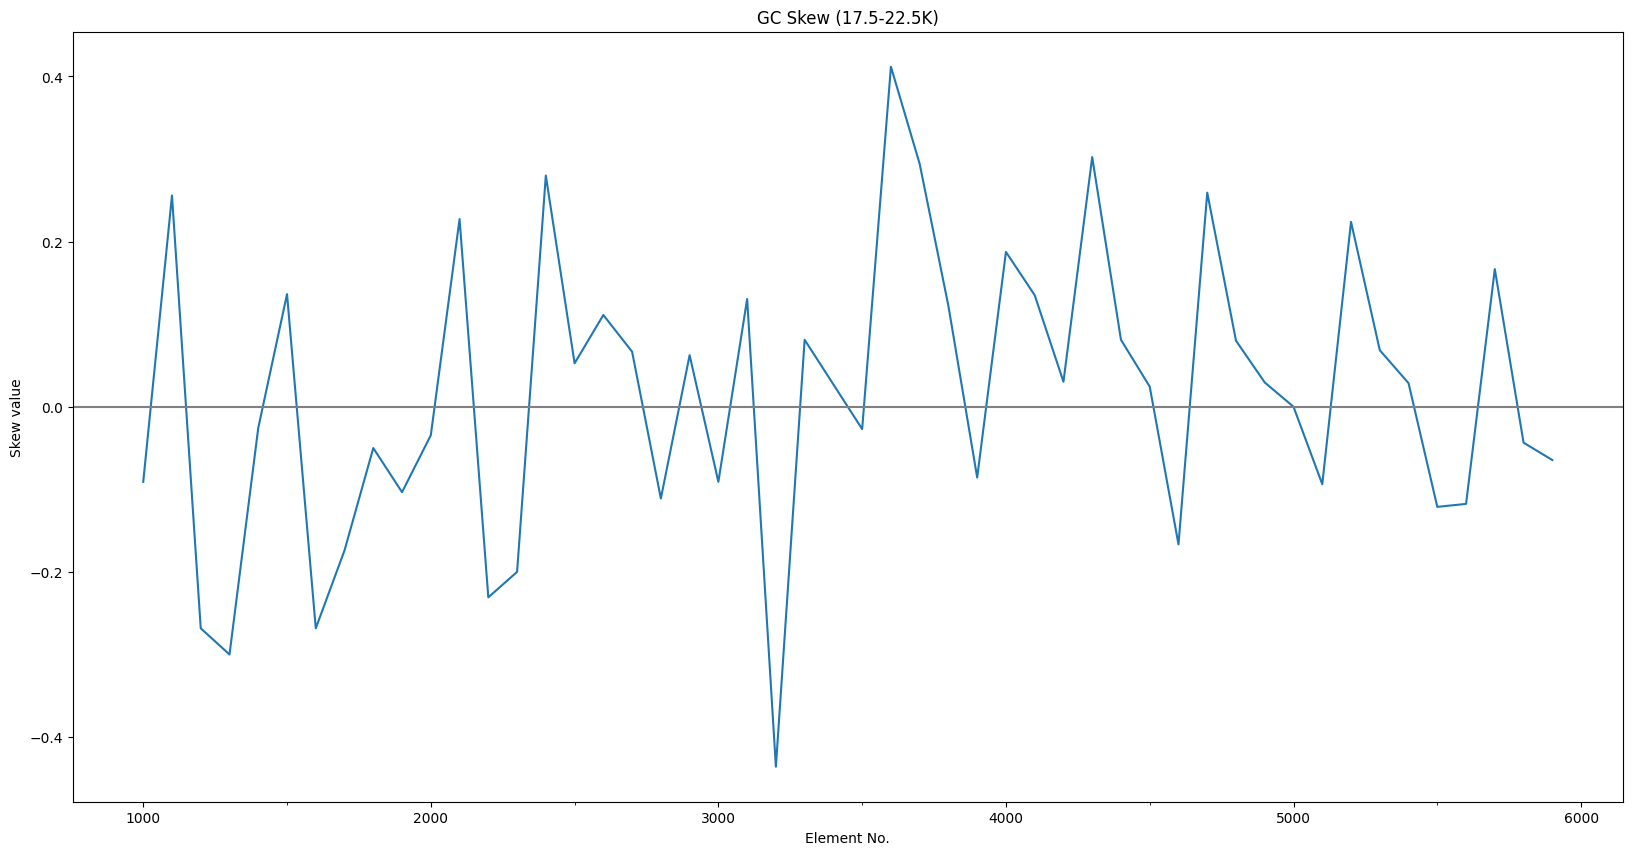

In [440]:
window_size = 100

border_left = 1000
border_right = 6000

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(500))
ax17_23.xaxis.set_major_locator(MultipleLocator(1000))
ax17_23.axhline(0, color='grey')

plt.show()


4840 и 6360, похоже, являются крайними точками перед началом вставки при текущем разрешении.

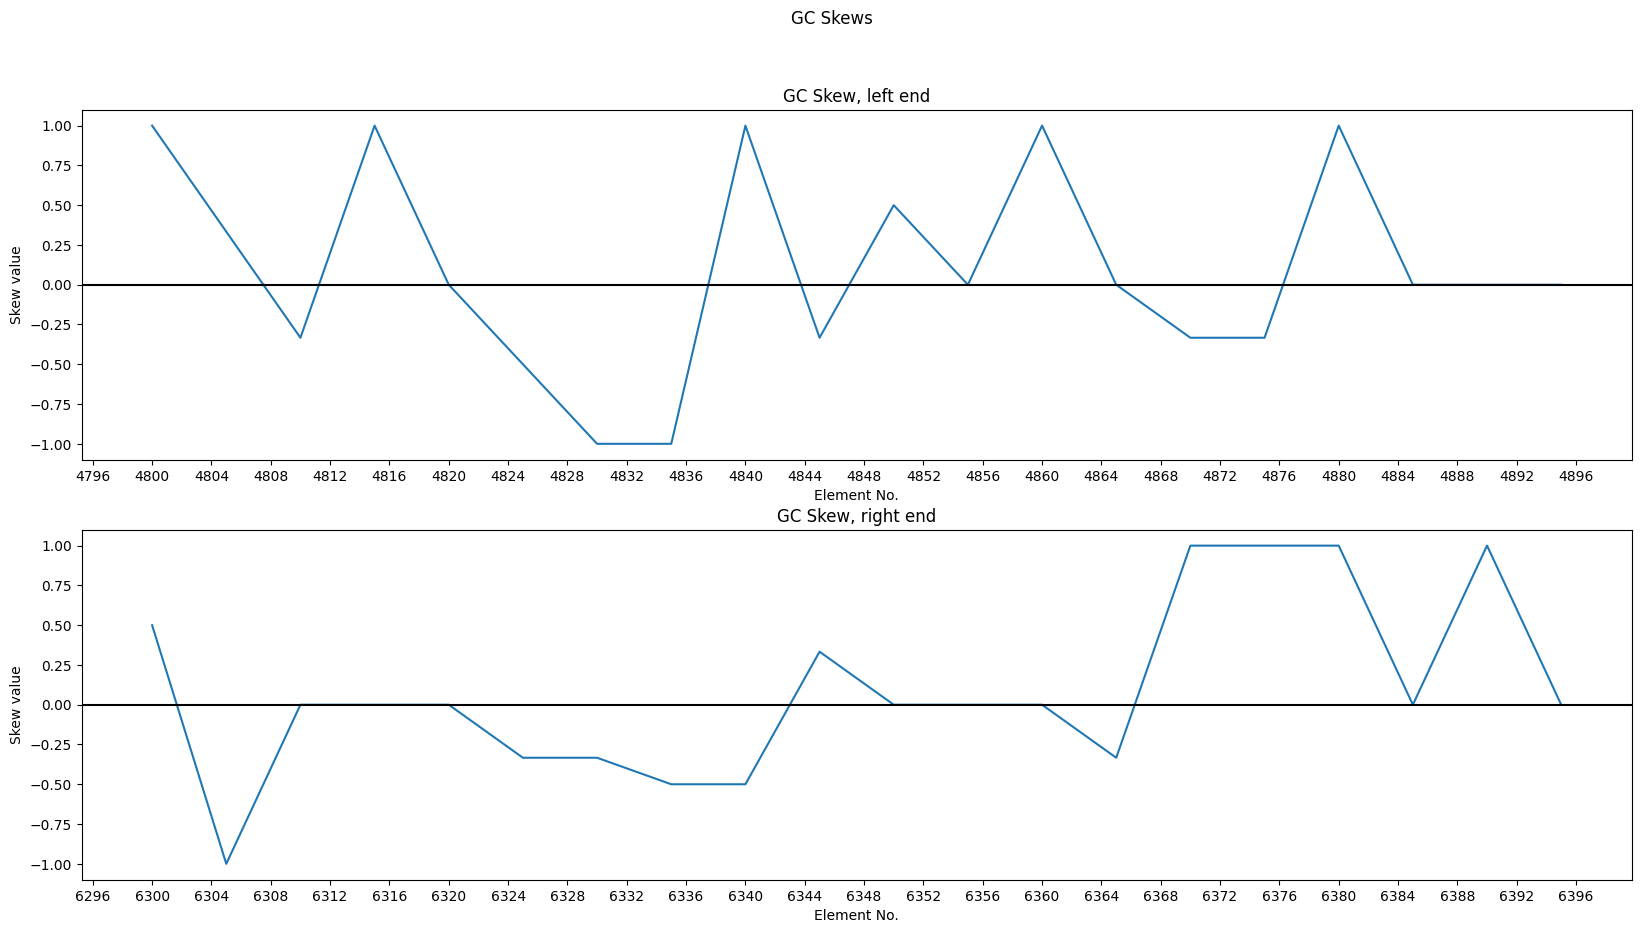

In [371]:
window_size1 = 5
fig_3, (ax_l, ax_r) = plt.subplots(2, 1, figsize=(20, 10))
fig_3.suptitle("GC Skews")

border_left_l = 4800
border_right_l = 4900

seq_l = seq_orig[border_left_l:border_right_l]
skew_l = SU.GC_skew(seq_l, window_size1)

ax_l.set_title("GC Skew, left end")
ax_l.plot(range(border_left_l, border_right_l, window_size1), skew_l)
ax_l.set_xlabel("Element No.")
ax_l.set_ylabel("Skew value")
ax_l.xaxis.set_major_locator(MultipleLocator(4))
ax_l.axhline(0, color='black')

border_left_r = 6300
border_right_r = 6400

seq_r = seq_orig[border_left_r:border_right_r]
skew_r = SU.GC_skew(seq_r, window_size1)

ax_r.set_title("GC Skew, right end")
ax_r.plot(range(border_left_r, border_right_r, window_size1), skew_r)
ax_r.set_xlabel("Element No.")
ax_r.set_ylabel("Skew value")
ax_r.xaxis.set_major_locator(MultipleLocator(4))
ax_r.axhline(0, color='black')


Вряд ли из рисунка выше можно вывести более точное решение.

#### Ответ

**Правая граница** = 4840

**Левая граница** = 6360

## Case 4

Original record length: 1638326


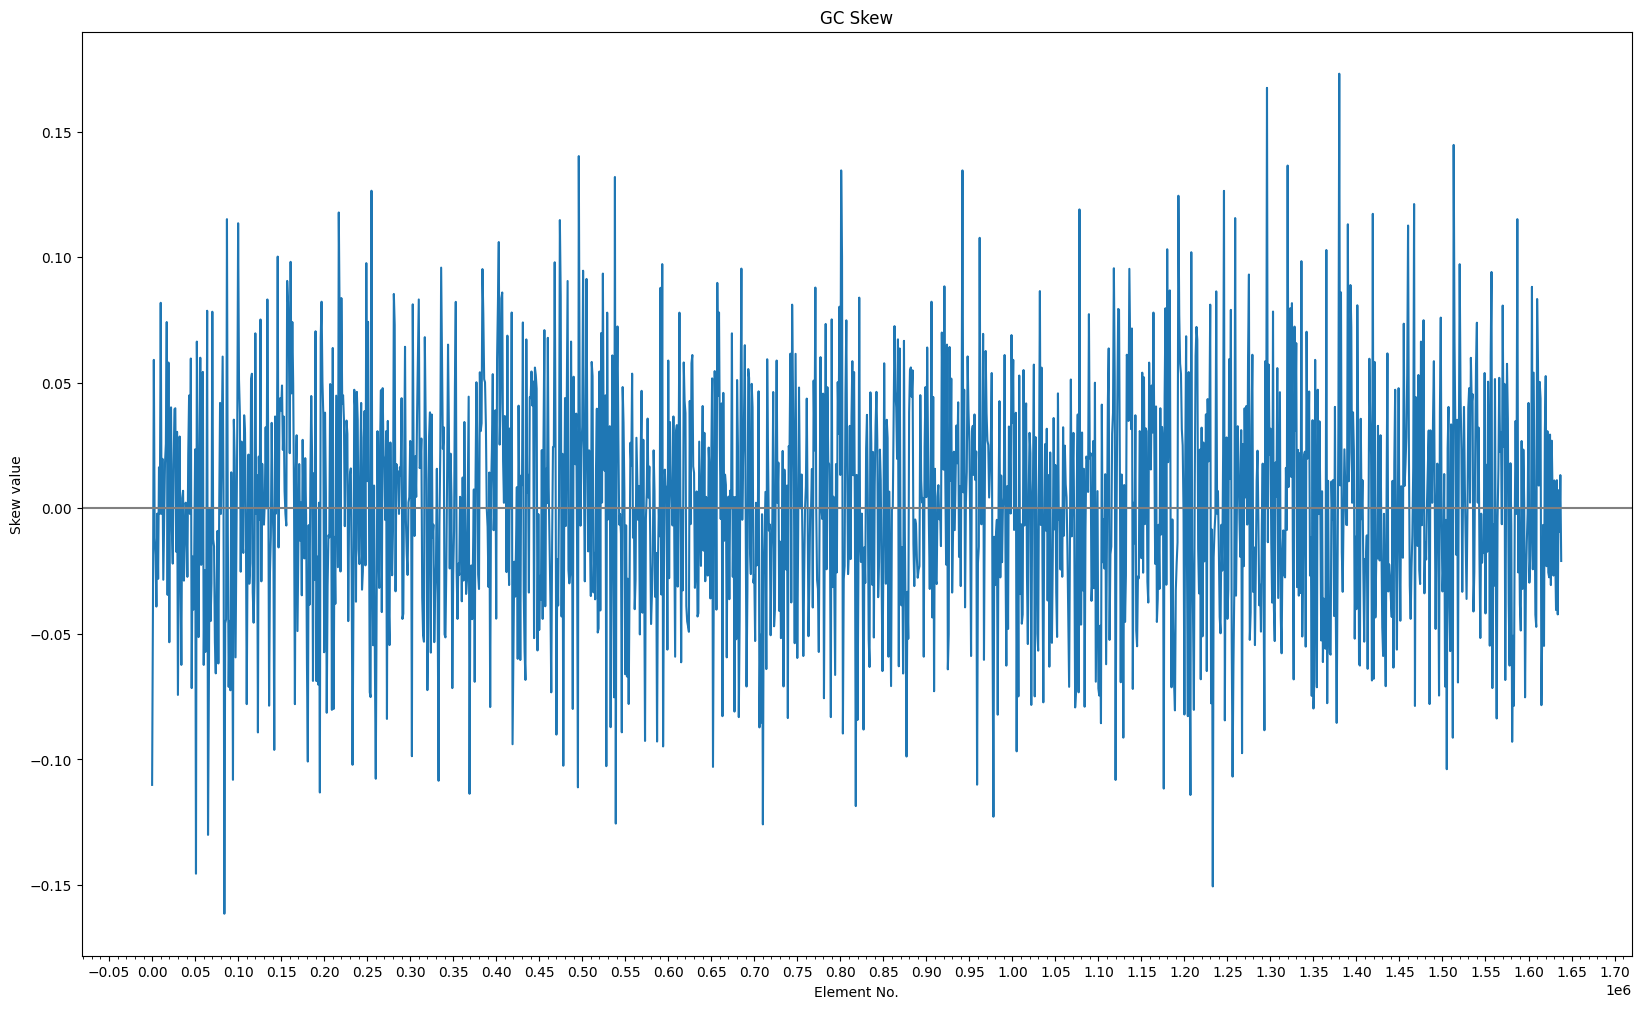

In [444]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
seq_orig = ""

with open("04.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record


print(f'Original record length: {seq_orig.__len__()}')

current_sub = ""
current_max_insertion = ""

window_size =1000

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 12))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(10000))
ax.xaxis.set_major_locator(MultipleLocator(50000))
ax.axhline(0, color='grey')
plt.show()


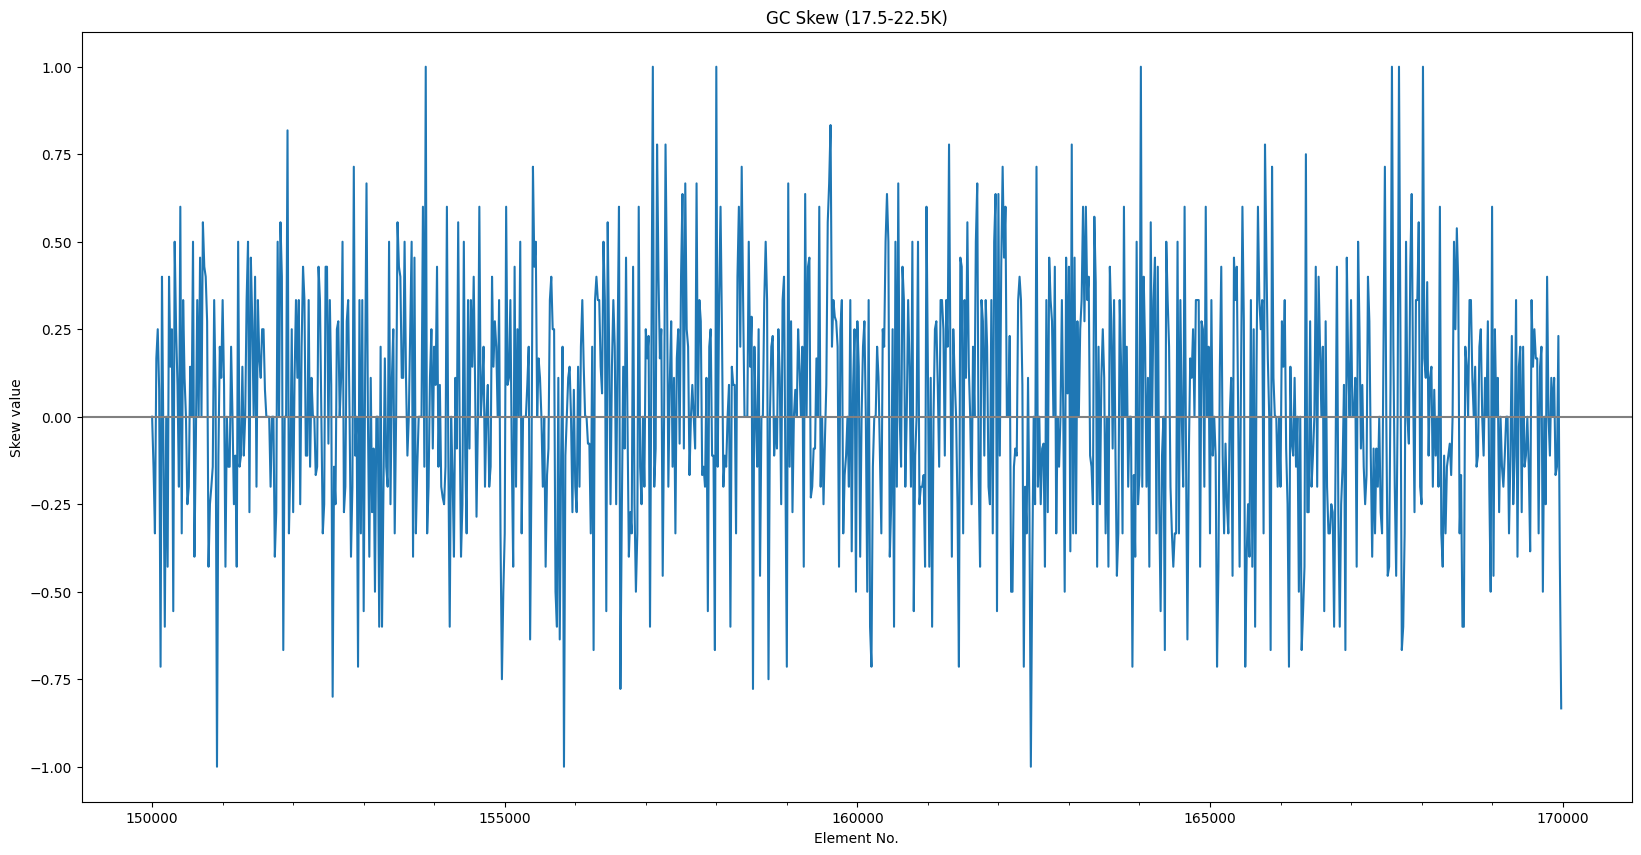

In [406]:
window_size = 20

border_left = 3
border_right = 170000

seq_17_23 = seq_orig[border_left:border_right]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew (17.5-22.5K)")
ax17_23.plot(range(border_left, border_right, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(1000))
ax17_23.xaxis.set_major_locator(MultipleLocator(5000))
ax17_23.axhline(0, color='grey')

plt.show()